In [1]:
#Useful ibrarires and functions
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import trange
from IPython.display import Video

from flygym.mujoco import Parameters, NeuroMechFly
from flygym.mujoco.arena import FlatTerrain
from flygym.mujoco.arena.tethered import Tethered
from flygym.mujoco.examples.common import PreprogrammedSteps
from flygym.mujoco.examples.cpg_controller import CPGNetwork

from gymnasium import spaces
from gymnasium.utils.env_checker import check_env
import cv2

In [2]:
#Implementing a standard tripod gait for the walk
#Taken from exercices sessions.
_tripod_phase_biases = np.pi * np.array(
    [
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0, 1],
        [1, 0, 1, 0, 1, 0],
    ]
)
_tripod_coupling_weights = (_tripod_phase_biases > 0) * 10

In [3]:
#Implementing a windy arena with a laminar wind
from dm_control.mjcf.physics import Physics


class WindArena(FlatTerrain):
    def __init__(
        self,

        #Change wind direction here
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
        wind_vector=[0, 3, 0],
        #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

        medium_density=0.01,
        medium_viscosity=0.01,
        **kwargs
    ):
        super().__init__(**kwargs)
        self._add_wind(wind_vector, medium_density, medium_viscosity)
        self.wind_vector = wind_vector

    def _add_wind(self, wind_vector, medium_density, medium_viscosity):
        # Here we directly change the fields of the xml option element
        self.root_element.option.__setattr__("density", medium_density)
        self.root_element.option.__setattr__("viscosity", medium_viscosity)
        self.root_element.option.__setattr__("wind", wind_vector)
    

wind_arena = WindArena()

In [4]:
from typing import Any, Dict, Tuple

#Create a NeuromechFly Class with a fly that will be able to follow the wind in a windy area
class WindTurningNMF(NeuroMechFly):
    def __init__(
        self,
        preprogrammed_steps=None,
        intrinsic_freqs=np.ones(6) * 12,
        intrinsic_amps=np.ones(6) * 1,
        phase_biases=_tripod_phase_biases,
        coupling_weights=_tripod_coupling_weights,
        convergence_coefs=np.ones(6) * 20,
        init_phases=None,
        init_magnitudes=None,
        amplitude_range=(-0.5, 1.5),
        seed=0,
        **kwargs,
    ):
        # Initialize core NMF simulation
        self.all_stiffness = [0.006, 0.006, 0.006] #roll, yaw, pitch
        self.all_damping = [2e-4, 2e-4, 2e-4] #roll, yaw, pitch
        super().__init__(**kwargs)

        if preprogrammed_steps is None:
            preprogrammed_steps = PreprogrammedSteps()
        self.preprogrammed_steps = preprogrammed_steps
        self.intrinsic_freqs = intrinsic_freqs
        self.intrinsic_amps = intrinsic_amps
        self.phase_biases = phase_biases
        self.coupling_weights = coupling_weights
        self.convergence_coefs = convergence_coefs
        self.amplitude_range = amplitude_range

        # Define action and observation spaces
        self.action_space = spaces.Box(*amplitude_range, shape=(2,))

        # Initialize CPG network
        self.cpg_network = CPGNetwork(
            timestep=self.sim_params.timestep,
            intrinsic_freqs=intrinsic_freqs,
            intrinsic_amps=intrinsic_amps,
            coupling_weights=coupling_weights,
            phase_biases=phase_biases,
            convergence_coefs=convergence_coefs,
            seed=seed,
        )
        self.cpg_network.reset(init_phases, init_magnitudes)
    
    #Here we can change the stiffness and damping of the aristae
    def _set_joints_stiffness_and_damping(self):
            for joint in self.model.find_all("joint"):
                if joint.name in self.actuated_joints:
                    joint.stiffness = self.sim_params.joint_stiffness
                    joint.damping = self.sim_params.joint_damping
                elif "Arista" in joint.name:
                    if "roll" in joint.name:
                        joint.stiffness = self.all_stiffness[0]
                        joint.damping = self.all_damping[0]
                    elif "yaw" in joint.name:
                        joint.stiffness = self.all_stiffness[1]
                        joint.damping = self.all_damping[1]
                    else:
                        joint.stiffness = self.all_stiffness[2]
                        joint.damping = self.all_damping[2]
                        
                elif "Head" in joint.name:
                    joint.stiffness = 1000.0
                    joint.damping = 1000.0
                else:
                    joint.stiffness = self.sim_params.non_actuated_joint_stiffness
                    joint.damping = self.sim_params.non_actuated_joint_damping
            

    #Here we add sensors on the aristae       
    def _add_joint_sensors(self):
        self._arista_sensors = []
        self._debug_end_effectors = []

        for side in "LR":
            arista_sensor_joint = self.model.sensor.add(
                "jointpos", name=f"jointpos_{side}Arista", joint=f"joint_{side}Arista"
            )
            arista_sensor_joint_roll = self.model.sensor.add(
                "jointpos", name=f"jointpos_{side}Arista_roll", joint=f"joint_{side}Arista_roll"
            )
            arista_sensor_joint_yaw = self.model.sensor.add(
                "jointpos", name=f"jointpos_{side}Arista_yaw", joint=f"joint_{side}Arista_yaw"
            )
            arista_sensor_force = self.model.sensor.add(
                "jointactuatorfrc", name=f"jointactuatorfrc_{side}Arista", joint=f"joint_{side}Arista"
            )
            arista_sensor_force_roll = self.model.sensor.add(
                "jointactuatorfrc", name=f"jointactuatorfrc_{side}Arista_roll", joint=f"joint_{side}Arista"
            )
            arista_sensor_force_yaw = self.model.sensor.add(
                "jointactuatorfrc", name=f"jointactuatorfrc_{side}Arista_yaw", joint=f"joint_{side}Arista"
            )
            
            self._arista_sensors.append(arista_sensor_joint)
            self._arista_sensors.append(arista_sensor_joint_roll)
            self._arista_sensors.append(arista_sensor_joint_yaw) 
            self._arista_sensors.append(arista_sensor_force)
            self._arista_sensors.append(arista_sensor_force_roll)
            self._arista_sensors.append(arista_sensor_force_yaw)
            
        return super()._add_joint_sensors()
    

    #Retrieve the observations of the newly added sensors
    def get_observation(self):
        obs = super().get_observation()
        arista_obs = self.physics.bind(self._arista_sensors).sensordata
        obs["arista_joint_pos"] = np.concatenate((arista_obs[0:3].copy(), arista_obs[6:9].copy()))
        obs["arista_joint_force"] = np.concatenate((arista_obs[3:6].copy(), arista_obs[9:12].copy()))
        obs["arista_joint_pos_filtered"] = np.concatenate((arista_obs[0:3].copy(), arista_obs[6:9].copy()))
        body_pos = self.physics.bind(self._body_sensors).sensordata
        obs["body_pos"] = body_pos.copy()        
        
        return obs
    
    #TODO
    def _define_observation_space(self):
        _observation_space = {
            "joints": spaces.Box(
                low=-np.inf, high=np.inf, shape=(3, len(self.actuated_joints))
            ),
            "fly": spaces.Box(low=-np.inf, high=np.inf, shape=(4, 3)),
            "contact_forces": spaces.Box(
                low=-np.inf, high=np.inf, shape=(len(self.contact_sensor_placements), 3)
            ),
            # x, y, z positions of the end effectors (tarsus-5 segments)
            "end_effectors": spaces.Box(low=-np.inf, high=np.inf, shape=(6, 3)),
            "fly_orientation": spaces.Box(low=-np.inf, high=np.inf, shape=(3,)),
            "arista_joint_pos": spaces.Box(low=-np.inf, high=np.inf, shape=(4,)),
            "arista_joint_force": spaces.Box(low=-np.inf, high=np.inf, shape=(3,)),
            "arista_joint_pos_filtered": spaces.Box(low=-np.inf, high=np.inf, shape=(4,))
        }
        if self.sim_params.enable_vision:
            _observation_space["vision"] = spaces.Box(
                low=0,
                high=255,
                shape=(2, self._mujoco_config["vision"]["num_ommatidia_per_eye"], 2),
            )
        if self.sim_params.enable_olfaction:
            _observation_space["odor_intensity"] = spaces.Box(
                low=0,
                high=np.inf,
                shape=(self.arena.odor_dimensions, len(self._antennae_sensors)),
            )
        return spaces.Dict(_observation_space)

    def reset(self, seed=None, init_phases=None, init_magnitudes=None, **kwargs):
        obs, info = super().reset(seed=seed)
        self.cpg_network.random_state = np.random.RandomState(seed)
        self.cpg_network.intrinsic_amps = self.intrinsic_amps
        self.cpg_network.intrinsic_freqs = self.intrinsic_freqs
        self.cpg_network.reset(init_phases, init_magnitudes)
        #Reset the obs by hand
        obs["arista_joint_pos"] = np.zeros((4,))
        return obs, info

    def step(self, action):
        """Step the simulation forward one timestep.

        Parameters
        ----------
        action : np.ndarray
            Array of shape (2,) containing descending signal encoding
            turning.
        """
        # update CPG parameters
        amps = np.repeat(np.abs(action[:, np.newaxis]), 3, axis=1).flatten()
        freqs = self.intrinsic_freqs.copy()
        freqs[:3] *= 1 if action[0] > 0 else -1
        freqs[3:] *= 1 if action[1] > 0 else -1
        self.cpg_network.intrinsic_amps = amps
        self.cpg_network.intrinsic_freqs = freqs

        self.cpg_network.step()

        joints_angles = []
        adhesion_onoff = []
        for i, leg in enumerate(self.preprogrammed_steps.legs):
            # get target angles from CPGs and apply correction
            my_joints_angles = self.preprogrammed_steps.get_joint_angles(
                leg,
                self.cpg_network.curr_phases[i],
                self.cpg_network.curr_magnitudes[i],
            )
            joints_angles.append(my_joints_angles)

            # get adhesion on/off signal
            my_adhesion_onoff = self.preprogrammed_steps.get_adhesion_onoff(
                leg, self.cpg_network.curr_phases[i]
            )
            adhesion_onoff.append(my_adhesion_onoff)

        action = {
            "joints": np.array(np.concatenate(joints_angles)),
            "adhesion": np.array(adhesion_onoff).astype(int),
        }
        return super().step(action)

windturning_nmf = WindTurningNMF(Parameters())

In [5]:
#Declare simulation parameters

run_time = 3

contact_sensor_placements = [
    f"{leg}{segment}"
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

sim_params = Parameters(
    timestep=1e-4,
    render_mode="saved",
    render_camera="Animat/camera_top",
    #render_camera="Animat/camera_front_zoomin",
    render_playspeed=0.5,
    enable_adhesion=True
)

nmf = WindTurningNMF(
    sim_params = sim_params,
    arena = wind_arena,
    contact_sensor_placements=contact_sensor_placements,
    spawn_pos=(0,0,0.2),
)

In [6]:
#Run the simulation
obs_list = []
magnitude_hist = []
end_effector_L = []
end_effector_R = []

AverageWindowL = np.array([])
AverageWindowR = np.array([])

target_num_steps = int(run_time / nmf.timestep)

obs, info = nmf.reset(seed=0)

for i in trange(target_num_steps) :
    curr_time = i * nmf.sim_params.timestep #Curr_time is always declared in the exercises but never used

    #The aristae joint posed will be averaged through a sliding window to obtain a smoother signal
    AverageWindowL=np.append(AverageWindowL,obs["arista_joint_pos"][1])
    AverageWindowR=np.append(AverageWindowR,obs["arista_joint_pos"][3])

    if(len(AverageWindowL)>=2000):
       AverageWindowL=np.delete(AverageWindowL,0)
       AverageWindowR=np.delete(AverageWindowR,0)

    obs["arista_joint_pos_filtered"][1]=np.mean(AverageWindowL)
    obs["arista_joint_pos_filtered"][3]=np.mean(AverageWindowR)

    L = obs["arista_joint_pos_filtered"][1]
    R = obs["arista_joint_pos_filtered"][3]

    #The fly walk straight or starts turning if a bias indicating wind is sensed in the antenae
    
    if((L-R)>0.006) :
        action=np.array([1, 0.2])
    elif((R-L)>0.006) :
        action=np.array([0.2, 1])
    else :
        action = np.array([1, 1])
    
    action = np.array([1,1])
    
    
    obs, reward, terminated, truncated, info = nmf.step(action)

    obs_list.append(obs)    

    end_effector_L.append(nmf.physics.named.data.qpos[f"Animat/joint_LArista"].copy())
    end_effector_R.append(nmf.physics.named.data.qpos[f"Animat/joint_RArista"].copy())
    magnitude_hist.append(nmf.cpg_network.curr_magnitudes.copy())

    nmf.render()



100%|██████████| 30000/30000 [02:04<00:00, 240.38it/s]


In [7]:
#Save the video
title = "Video Wind flow = ["+str(wind_arena.wind_vector[0])+" ; "+str(wind_arena.wind_vector[1])+"]"
nmf.save_video(("outputs/"+title + "_NONE.mp4"), 0)

In [8]:
#Play the video

Video(("outputs/"+title + "_NONE.mp4"))

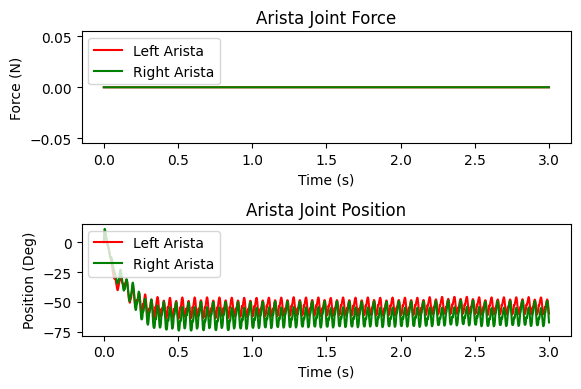

In [9]:
#Plot the aristae joint position and force
#Also used to compare between versions
version = "new_version" # just to save the graphs with a different name, other is "last version"
# Simulating data for illustration purposes
arista_joint_pos = np.array([obs["arista_joint_pos"] for obs in obs_list])
arista_joint_force = np.array([obs["arista_joint_force"] for obs in obs_list])
time = np.linspace(0, run_time, target_num_steps)

# Create a figure with 3 subplots (1 row, 3 columns)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4))

# First subplot - Arista pitch joint Force
ax1.plot(time, arista_joint_force[:, 0], 'r', label="Left Arista")
ax1.plot(time, arista_joint_force[:, 3], 'g', label="Right Arista")
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Force (N)')
ax1.legend(loc='upper left')
ax1.set_title("Arista Joint Force")

# Second subplot - Arista pitch joint position
ax2.plot(time, arista_joint_pos[:, 0] * 360 / 2 * math.pi, 'r', label="Left Arista")
ax2.plot(time, arista_joint_pos[:, 3] * 360 / 2 * math.pi, 'g', label="Right Arista")
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Position (Deg)')
ax2.legend(loc='upper left')
ax2.set_title("Arista Joint Position")


plt.tight_layout()

fig.savefig("graphs/" + "joint_force_vs_pos_" + "old_version_" + title + ".png", dpi=300, bbox_inches='tight')

plt.show()

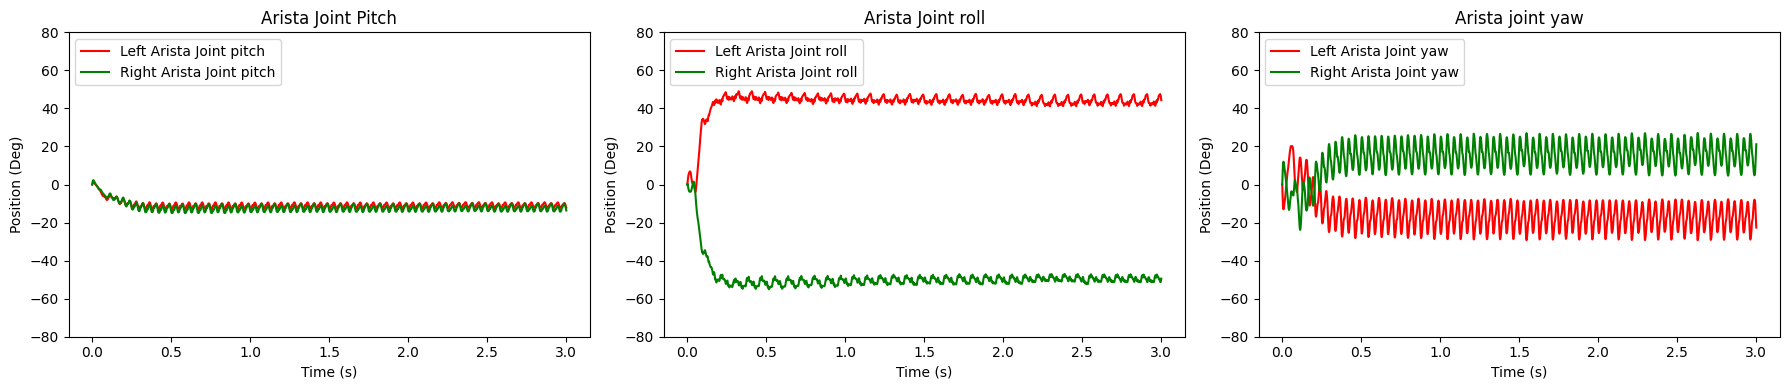

In [10]:
# Comparison between the different arista joints (pitch, roll, yaw)

# Create a figure with 3 subplots (1 row, 3 columns)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

# First subplot - Arista Pitch
ax1.plot(time, arista_joint_pos[:, 0] * 360 / math.pi, 'r', label="Left Arista Joint pitch")
ax1.plot(time, arista_joint_pos[:, 3] * 360 / math.pi, 'g', label="Right Arista Joint pitch")
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Position (Deg)')
ax1.legend(loc='upper left')
ax1.set_title("Arista Joint Pitch")

# Second subplot - Arista Roll
ax2.plot(time, arista_joint_pos[:, 1] * 360 / math.pi, 'r', label="Left Arista Joint roll")
ax2.plot(time, arista_joint_pos[:, 4] * 360 / math.pi, 'g', label="Right Arista Joint roll")

ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Position (Deg)')
ax2.legend(loc='upper left')
ax2.set_title("Arista Joint roll")

# Third subplot - Arista Yaw
ax3.plot(time, arista_joint_pos[:, 2] * 360 / math.pi, 'r', label="Left Arista Joint yaw")
ax3.plot(time, arista_joint_pos[:, 5] * 360 / math.pi, 'g', label="Right Arista Joint yaw")
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Position (Deg)')
ax3.legend(loc='upper left')
ax3.set_title("Arista joint yaw")

ax1.set_ylim(-80, 80)
ax2.set_ylim(-80, 80)
ax3.set_ylim(-80, 80)
# Adjust spacing between subplots
fig.savefig("graphs/" + title + ".png", dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()